In [3]:
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Pt. 1 Threshold-Based Segmentation

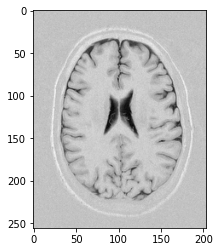

In [4]:
img = cv2.imread('materials/brain.png',0)
plt.imshow(img, 'gray')

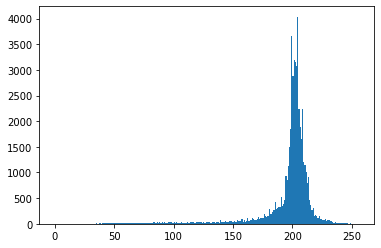

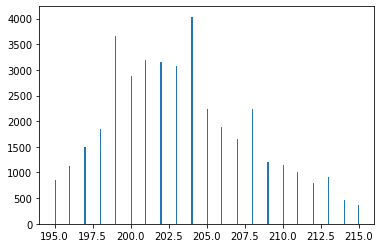

In [5]:
plt.hist(img.ravel(),256,[0,256]); plt.show()
plt.hist(img.ravel(),256,[195,215]); plt.show()

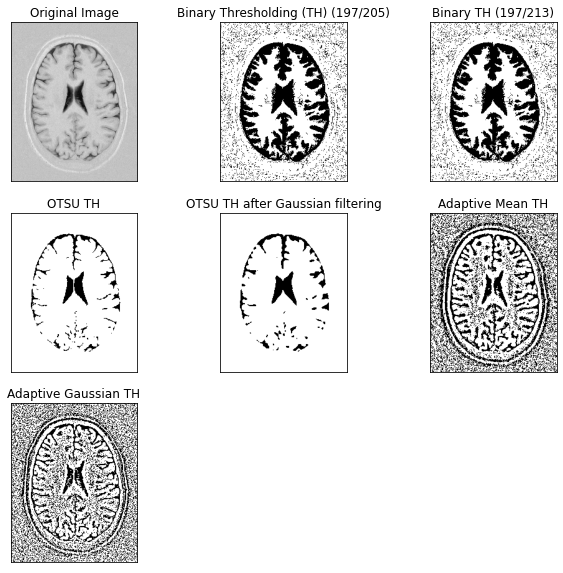

<Figure size 1440x720 with 0 Axes>

In [6]:
## TODO add image arithmetic for full points

plt.subplots_adjust(left=None, bottom=None, right=1.5, top=2, wspace=None, hspace=None)

ret,th1 = cv2.threshold(img,197,205,cv2.THRESH_BINARY)
ret,th2 = cv2.threshold(img,197,213,cv2.THRESH_BINARY)
ret,otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur = cv2.GaussianBlur(img,(5,5),0)
ret, otsuG = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
adm = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
adg = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

images = [img, th1, th2, otsu, otsuG, adm, adg]
titles = ['Original Image', 'Binary Thresholding (TH) (197/205)',
            'Binary TH (197/213)','OTSU TH', 'OTSU TH after Gaussian filtering',
            'Adaptive Mean TH', 'Adaptive Gaussian TH']
for i in range(len(images)):
    plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.show()

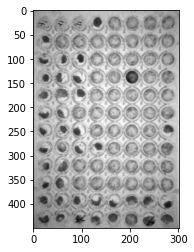

In [7]:
tray = cv2.imread('materials/tray.png',0)
plt.imshow(tray, 'gray')
t_hh, t_ww = tray.shape[:2]
t_max = max(t_hh, t_ww)

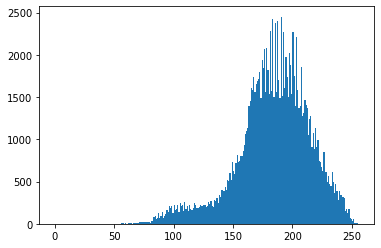

In [8]:
plt.hist(tray.ravel(),256,[0,256]); plt.show()

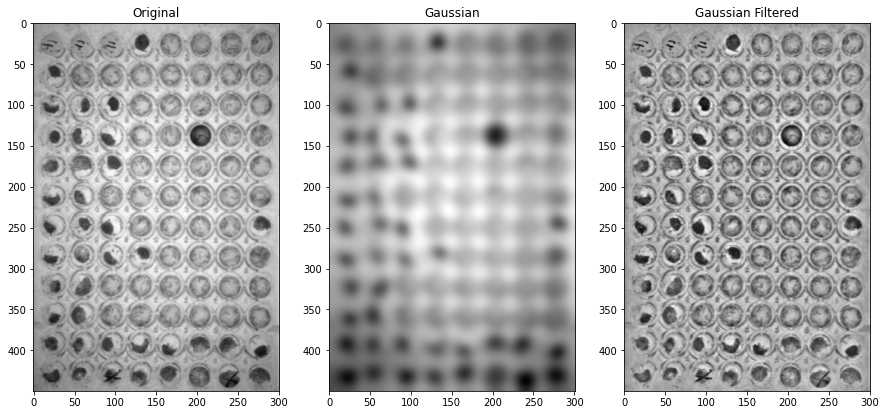

In [9]:
sigma = int(5 * t_max / 300)
blur = cv2.GaussianBlur(tray,(0,0),sigma,sigma)

plt.figure(figsize=(15, 8))
plt.subplot(131),plt.imshow(tray, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(blur, 'gray'),plt.title('Gaussian')
plt.subplot(133),plt.imshow(tray-blur+100, 'gray'),plt.title('Gaussian Filtered')
plt.show()

## Pt. 2 Labelling

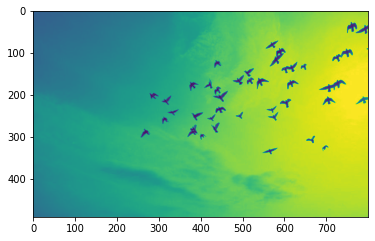

In [10]:
birds = cv2.imread('materials/birds.jpg', 0)
birds_cl = cv2.imread('materials/birds.jpg')
plt.imshow(birds)

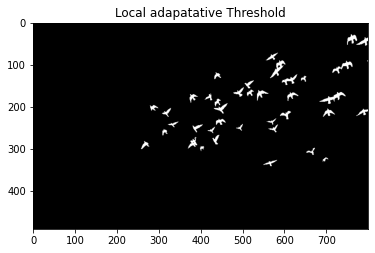

In [11]:

thresh = cv2.adaptiveThreshold(birds, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 80)
thresh = cv2.bitwise_not(thresh)
plt.title('Local adapatative Threshold')
plt.imshow(thresh, cmap="gray", vmin=0, vmax=255)

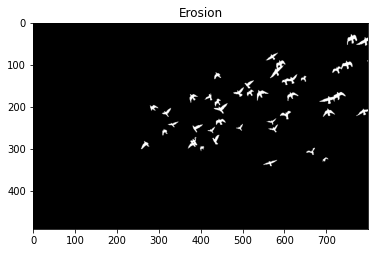

In [12]:
# Dilatation
# trying to separate the birds from each other
# not possible in some cases
kernel = np.ones((1,1), np.uint8)
img_eroded = cv2.erode(thresh, kernel, iterations=1)
plt.title('Erosion')
plt.imshow(img_eroded, cmap="gray")

objects number is: 40


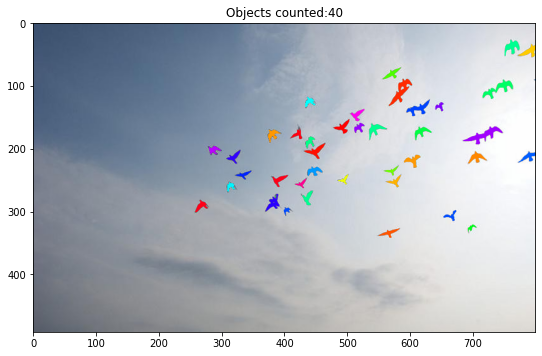

In [13]:
ret, labels = cv2.connectedComponents(img_eroded)

# create random labels without duplicates and assign them to the pixels
random_labels = random.sample(range(1, 255), len(np.unique(labels)))
label_hue = labels
for i, x in enumerate(np.unique(labels)[1:]):
    label_hue[label_hue==x] = random_labels[i]
# convert hue labels to int
label_hue = np.uint8(label_hue)
# create blank channel
blank_ch = 255 * np.ones_like(label_hue)
# merge into 3 channels
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# convert label image to bgr color space
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
# convert image color space to same as labels so we can combine them
birds_BGR = cv2.cvtColor(birds_cl, cv2.COLOR_BGR2RGB)
labeled_img[label_hue == 0] = birds_BGR[(label_hue == 0)]

plt.figure(figsize=(9,9))
plt.title('Objects counted:'+ str(ret-1))
plt.imshow(labeled_img)
print('objects number is:', ret-1)

## Pt. 3 Stereo Imagery

see DisparityImages.py